# Vanilla Autoencoders

## Initialization

In [1]:
# Install required libraries
!pip install -q torch_snippets torch_summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 639.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 41.1 MB/s eta

In [2]:
# Import libraries
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torchsummary import summary
from torch_snippets import *

print(f"PyTorch Version: {torch.__version__}")
!nvidia-smi # check if GPU is available
%matplotlib inline

PyTorch Version: 2.2.1+cu121

Fri Mar 22 06:09:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda

In [4]:
# Set up a normalization transform for the images
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [5]:
# Create train and validation datasets
train_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

# Create a function to retrieve the dataloaders
def load_data(batch_size = 256):
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

100%|██████████| 9912422/9912422 [00:00<00:00, 164492766.57it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 91561370.99it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86934388.35it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17334421.08it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [6]:
# Create a class for the AutoEncoder model
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # Bottleneck layer size
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1) # Flatten the input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28) # Reshape the output to the original shape
        return x

In [7]:
# Create a mock-up model and print summary
model = AutoEncoder(latent_dim=3).to(device)
summary(model, torch.zeros(1, 1, 28, 28).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [8]:
# Create a function to train the model on a batch of data
def train_batch(model, data, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data)
    loss.backward()
    optimizer.step()
    return loss

# Create a function to validate the model on a batch of data
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    output = model(data)
    return criterion(output, data) # Return the loss

EPOCH: 1.000  train_loss: 0.253  val_loss: 0.190  (34.63s - 138.51s remaining)
EPOCH: 2.000  train_loss: 0.176  val_loss: 0.167  (55.63s - 83.45s remaining)
EPOCH: 3.000  train_loss: 0.161  val_loss: 0.158  (75.98s - 50.65s remaining)
EPOCH: 4.000  train_loss: 0.155  val_loss: 0.152  (96.79s - 24.20s remaining)
EPOCH: 5.000  train_loss: 0.150  val_loss: 0.149  (117.39s - 0.00s remaining)


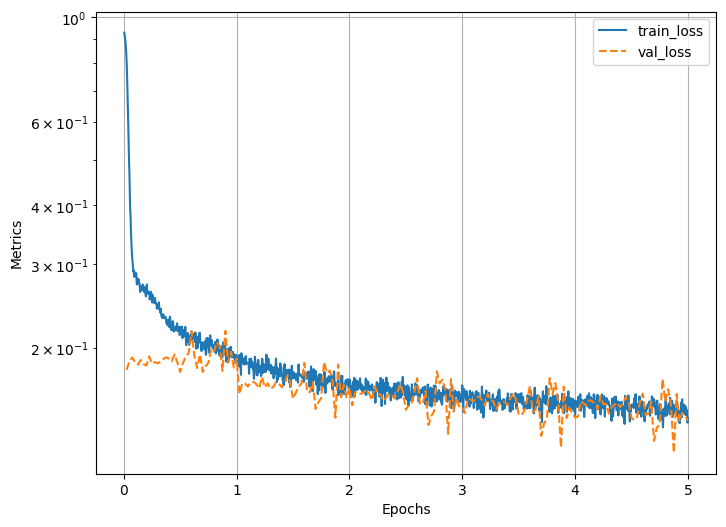

In [9]:
# Train the model
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
train_dl, val_dl = load_data()
n_epochs = 5
log = Report(n_epochs)

for epoch in range(n_epochs):
    n = len(train_dl)
    for i, (data, _) in enumerate(train_dl):
        loss = train_batch(model, data, criterion, optimizer)
        log.record(epoch+(i+1)/n, train_loss=loss, end='\r')

    n = len(val_dl)
    for i, (data, _) in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
        log.record(epoch+(i+1)/n, val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

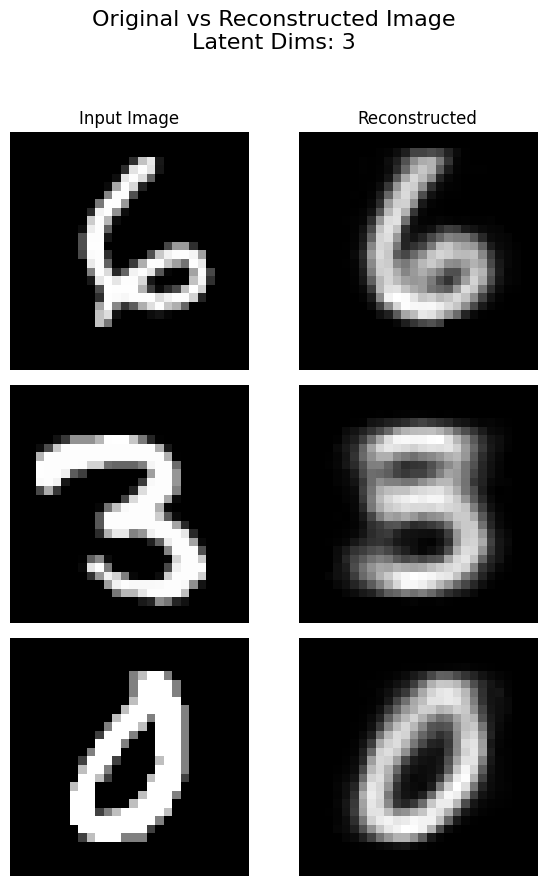

In [10]:
# Validate the model
num_samples = 3
fig, axs = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))
fig.suptitle('Original vs Reconstructed Image\nLatent Dims: 3', fontsize=16)

for i in range(num_samples):
    # Get a random image from the validation dataset
    idx = np.random.randint(len(val_ds))
    image, _ = val_ds[idx]
    pred_image = model(image[None])[0]

    # Plot the original image in the first column
    show(image[0], ax=axs[i, 0], title='Input Image' if i == 0 else "")
    # Plot the reconstructed image in the second column
    show(pred_image[0], ax=axs[i, 1], title='Reconstructed' if i == 0 else "")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout, leaving space for the suptitle
plt.show()

EPOCH: 1.000  train_loss: 0.263  val_loss: 0.213  (21.46s - 85.82s remaining)
EPOCH: 2.000  train_loss: 0.204  val_loss: 0.195  (43.19s - 64.79s remaining)
EPOCH: 3.000  train_loss: 0.190  val_loss: 0.186  (64.25s - 42.83s remaining)
EPOCH: 4.000  train_loss: 0.182  val_loss: 0.179  (85.36s - 21.34s remaining)
EPOCH: 5.000  train_loss: 0.177  val_loss: 0.175  (105.77s - 0.00s remaining)


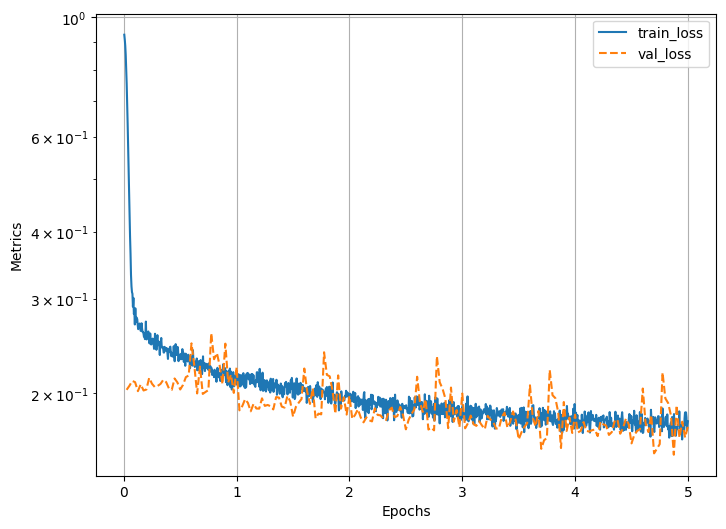

EPOCH: 1.000  train_loss: 0.259  val_loss: 0.198  (21.19s - 84.75s remaining)
EPOCH: 2.000  train_loss: 0.181  val_loss: 0.169  (41.48s - 62.21s remaining)
EPOCH: 3.000  train_loss: 0.164  val_loss: 0.158  (61.38s - 40.92s remaining)
EPOCH: 4.000  train_loss: 0.156  val_loss: 0.152  (82.13s - 20.53s remaining)
EPOCH: 5.000  train_loss: 0.151  val_loss: 0.148  (103.30s - 0.00s remaining)


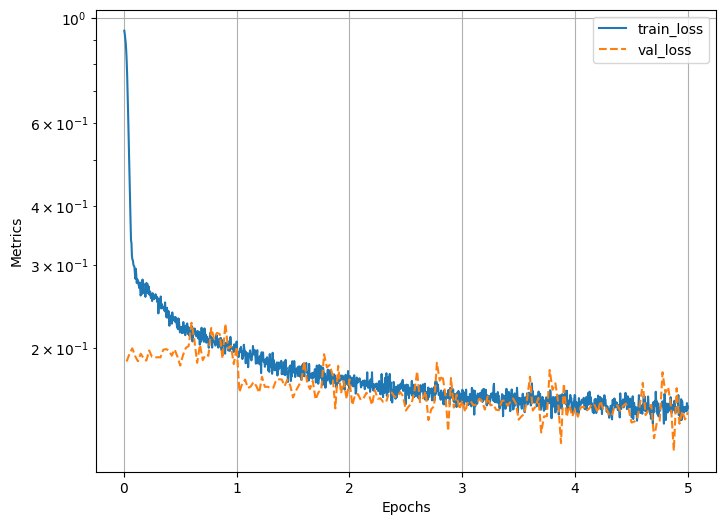

EPOCH: 1.000  train_loss: 0.264  val_loss: 0.180  (20.99s - 83.97s remaining)
EPOCH: 2.000  train_loss: 0.161  val_loss: 0.146  (41.64s - 62.46s remaining)
EPOCH: 3.000  train_loss: 0.138  val_loss: 0.132  (61.73s - 41.15s remaining)
EPOCH: 4.000  train_loss: 0.128  val_loss: 0.125  (81.71s - 20.43s remaining)
EPOCH: 5.000  train_loss: 0.123  val_loss: 0.121  (101.65s - 0.00s remaining)


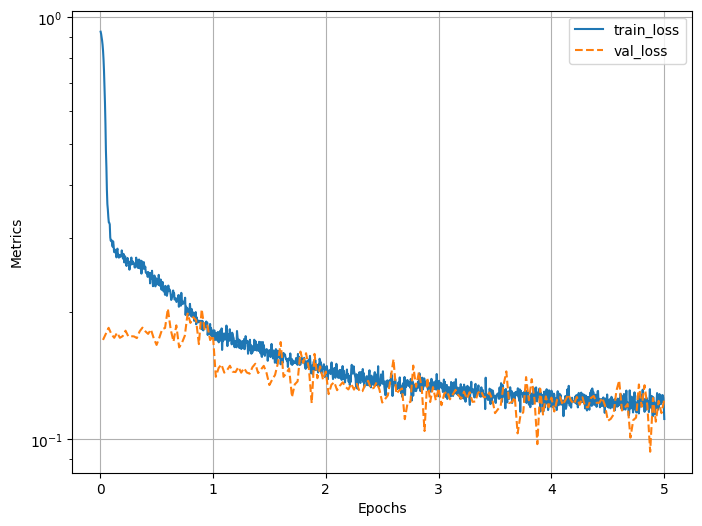

EPOCH: 1.000  train_loss: 0.241  val_loss: 0.144  (20.31s - 81.24s remaining)
EPOCH: 2.000  train_loss: 0.129  val_loss: 0.113  (41.60s - 62.41s remaining)
EPOCH: 3.000  train_loss: 0.105  val_loss: 0.099  (61.27s - 40.85s remaining)
EPOCH: 4.000  train_loss: 0.097  val_loss: 0.093  (81.63s - 20.41s remaining)
EPOCH: 5.000  train_loss: 0.093  val_loss: 0.089  (101.79s - 0.00s remaining)


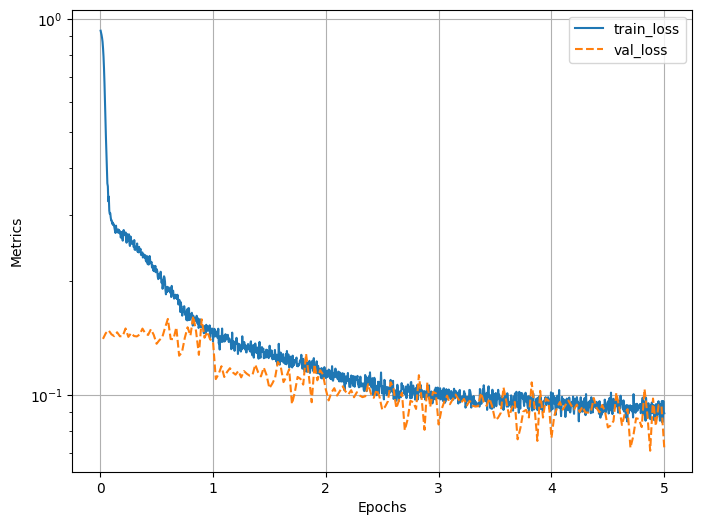

EPOCH: 1.000  train_loss: 0.239  val_loss: 0.132  (19.83s - 79.33s remaining)
EPOCH: 2.000  train_loss: 0.111  val_loss: 0.096  (40.19s - 60.28s remaining)
EPOCH: 3.000  train_loss: 0.087  val_loss: 0.078  (60.00s - 40.00s remaining)
EPOCH: 4.000  train_loss: 0.076  val_loss: 0.070  (79.98s - 20.00s remaining)
EPOCH: 5.000  train_loss: 0.068  val_loss: 0.064  (100.27s - 0.00s remaining)


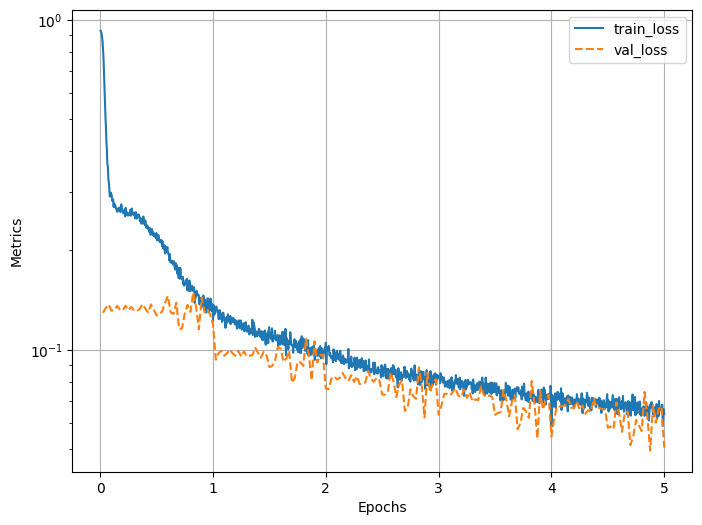

In [11]:
# Create a function to train the AutoEncoder model with different latent dimensions (bottleneck layer sizes)
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim=latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    train_dl, val_dl = load_data()
    n_epochs = 5
    log = Report(n_epochs)

    for epoch in range(n_epochs):
        n = len(train_dl)
        for i, (data, _) in enumerate(train_dl):
            loss = train_batch(model, data, criterion, optimizer)
            log.record(epoch+(i+1)/n, train_loss=loss, end='\r')

        n = len(val_dl)
        for i, (data, _) in enumerate(val_dl):
            loss = validate_batch(model, data, criterion)
            log.record(epoch+(i+1)/n, val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

# Train the AutoEncoder model with different latent dimensions
autoencoders = [train_aec(dim) for dim in [2, 3, 5, 10, 50]]

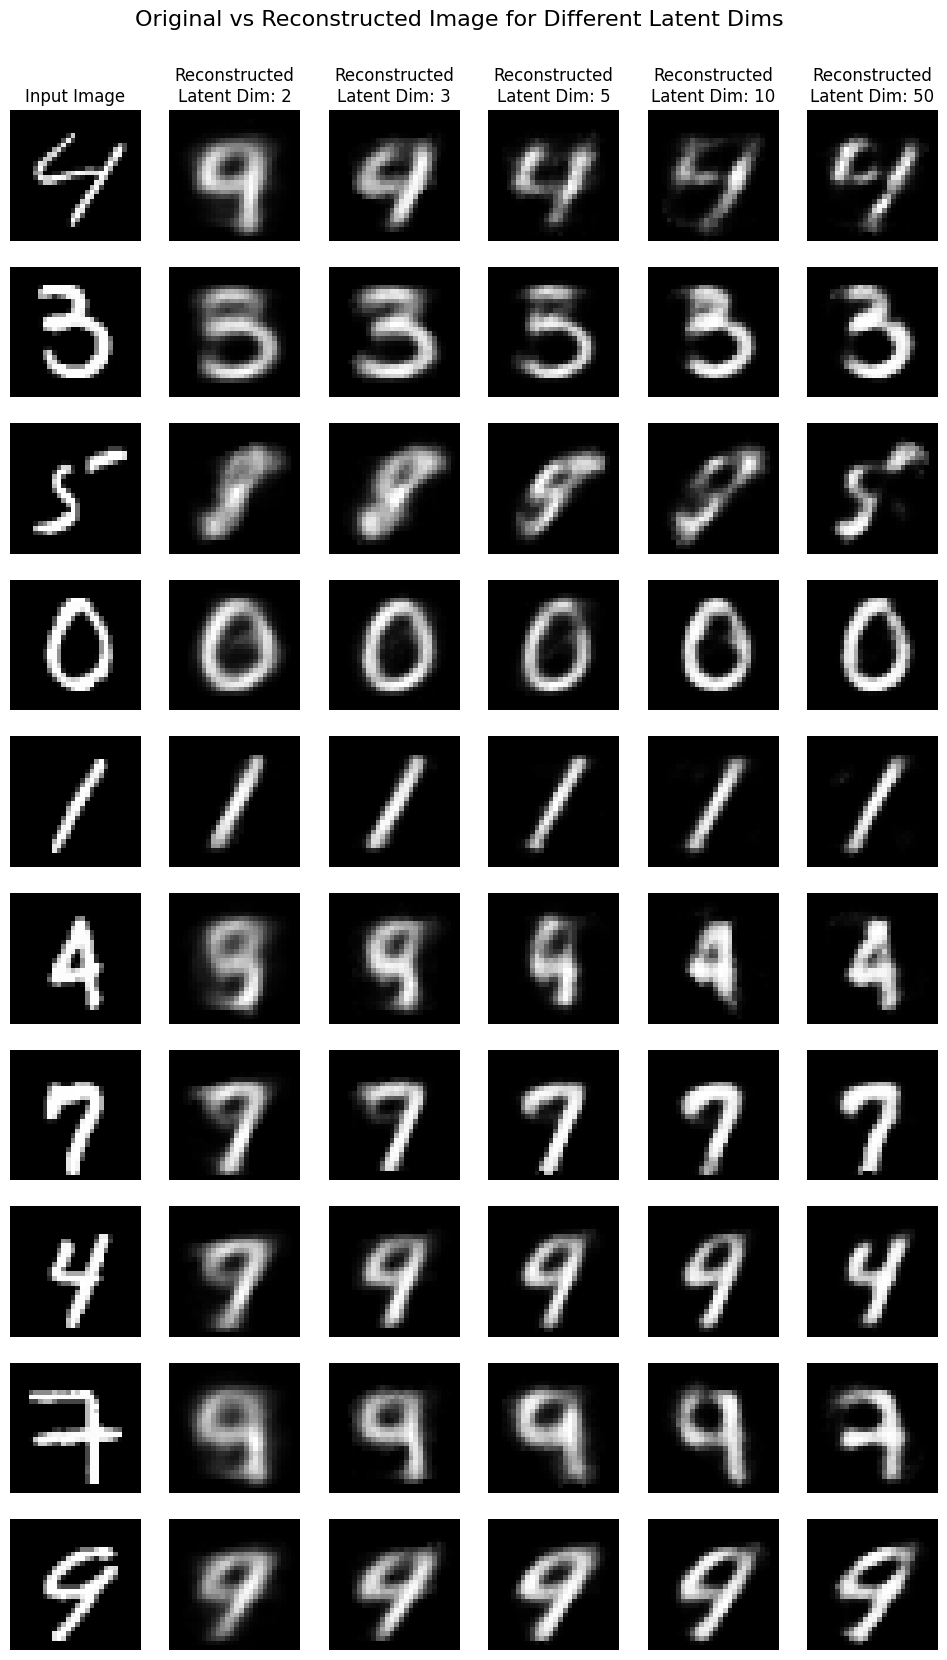

In [34]:
# Validate the AutoEncoder models
num_samples = 10
num_columns = len(autoencoders) + 1
fig, axs = plt.subplots(num_samples, num_columns, figsize=(12, 2 * num_samples))
fig.suptitle('Original vs Reconstructed Image for Different Latent Dims', fontsize=16, y=0.93)

for i in range(num_samples):
    idx = np.random.randint(len(val_ds))
    image, _ = val_ds[idx]
    ax = axs[i, 0] if num_samples > 1 else axs[0]
    title = 'Input Image' if i == 0 else ""
    show(image[0], ax=ax, title=title)
    for j, model in enumerate(autoencoders, start=1):
        pred_image = model(image[None])[0]
        ax = axs[i, j] if num_samples > 1 else axs[j]
        title = f'Reconstructed\nLatent Dim: {model.latent_dim}' if i == 0 else ""
        show(pred_image[0], ax=ax, title=title, sz=6)
plt.show()